In [1]:
#libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import warnings
from shapely.geometry import Point
%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

## Inlezen

In [3]:
def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.apply(lambda v: dates[v])

# read data
path = '../data/data_tot.csv'

columns = ['ID', 'DATUM', 'TIJD', 'LOCOMS','PAR', 'WAARDE',
           'EHD', 'BGC', 'KWC', 'HDH', 'ANA', 'CPM', 'BEM',
           'BTN', 'GBD', 'LOC:COORDSRT', 'LOC:X', 'LOC:Y',
           'OGI', 'ANI', 'BHI', 'BMI', 'VAT', 'STA:RKSSTATUS', 
           'X_WGS', 'Y_WGS', 'X_RD', 'Y_RD']

omschrijvingen = ['ID', 'LOCOMS', 'ORGOMS', 'BTXCOD', 'BTXOMS',
                  'GBDOMS', 'OGIOMS', 'ANIOMS', 'BHIOMS',
                  'BMIOMS', 'VATOMS']

df = pd.read_csv(path, encoding='latin1', usecols=columns, index_col='ID', engine='c')

df.insert(0, 'DATUM:TIJD', lookup(df.DATUM + df.TIJD))
df.drop(['DATUM', 'TIJD'], axis=1, inplace=True)

In [4]:
domburg = {'Domburg badstrand': [51.566595, 3.492651]}
dronten = {'Drontermeerdijk, kilometer 0.4': [52.460994, 5,819641]}
heusden = {'Heusden Bernse Veer': [51.742304, 5.163070]}
diep = {'Hollandsch Diep (mond Dordtsche Kil west)':[51.720391, 4.619765]}
ouddorp = {'Ouddorp badstrand':[51.810782, 3.855651]}
tersch = {'Terschelling 4 km uit de kust':[53.4243, 5.1471]}

In [5]:
#df[df['LOCOMS'] == 'Domburg badstrand'].at['X_RD'] = 51.566595
df.X_RD.loc[df['LOCOMS'] == 'Domburg badstrand'] = 51.566595
df.Y_RD.loc[df['LOCOMS'] == 'Domburg badstrand'] = 3.492651

/home/jasper/.local/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
#epsg:28992 (RD coord sys)
rd_crs = '+proj=sterea +lat_0=52.15616055555555 +lon_0=5.38763888888889 +k=0.999908 +x_0=155000 +y_0=463000 \
            +ellps=bessel +units=m +towgs84=565.2369,50.0087,465.658,-0.406857330322398,0.350732676542563,-1.8703473836068,4.0812 +no_defs '
nld = gpd.read_file('../data/shapefiles/water')

In [7]:
#df_oms = pd.read_csv(path, encoding='latin1', usecols=omschrijvingen, index_col='ID')
df.to_csv('data_tot_df.csv')

In [8]:
knmi_path = '../data/knmi_data.txt'
knmi_df = pd.read_csv(knmi_path, header=97, skipinitialspace=True, parse_dates=['YYYYMMDD'])
knmi_df.drop(0, axis='index', inplace=True)
knmi_df['# STN'] = knmi_df['# STN'].astype('int64')
knmi_df.rename(columns={'# STN': 'STN'}, inplace=True)

/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Methodes

In [9]:
def plot_locatie_stof(loclijst, stoflijst, data):
    fig, ax = plt.subplots(1, figsize=(30,15))
    
    for s in stoflijst:
        stof_df = data.loc[data['PAR'] == s]
        ehd = stof_df[['EHD']].iloc[1][0]
        for l in loclijst:
            lijn = stof_df.loc[stof_df['LOCOMS'] == l]
            if len(lijn) > 0:
                lijn.plot('DATUM:TIJD', 'WAARDE', ax = ax, label = l+' '+s+' '+ehd)
            else:
                print(l + ' (' + s + ') : data niet aanwezig')
    
    plt.legend(loc=(1.01,0.8))
    plt.xlabel('Jaar')
    plt.show()

In [10]:
def plot_mean_hilo(dataframe, par, sortby):
    par_data = dataframe.loc[ dataframe['PAR'] == par].groupby('LOCOMS')['WAARDE'].agg({'Min':'min','Max':'max','Mean':'mean'})
    ehd = dataframe[['EHD']].loc[df.PAR == par].iloc[1][0]
    if len(par_data > 0):
        par_data.sort_values(by = sortby).plot(kind = 'barh', figsize = (25,25), title = 'Alle locaties (' + str(len(par_data)) + ') voor stof ' + par + ' ' + ehd)
        plt.xlabel(ehd, fontsize=20)
        plt.show()
    else:
        print('data niet aanwezig')

In [11]:
def map_mean_stof(stof, df, circlesize = 1, output = False):
    locoms = df[['LOCOMS', 'X_RD', 'Y_RD']].groupby('LOCOMS').max().dropna()
    
    geometry = [Point(xy) for xy in zip(locoms['X_RD'], locoms['Y_RD'])]
    geo_df = gpd.GeoDataFrame(geometry = geometry, index=locoms.index, crs = rd_crs).to_crs(epsg = '4326').reset_index()
    
    par_data = df.loc[ df['PAR'] == stof].groupby('LOCOMS')['WAARDE'].agg({'Min':'min','Max':'max','Mean':'mean'}).reset_index()
    if(len(par_data > 0)):
        geo_df = geo_df.merge(par_data, on = 'LOCOMS')
        
        map_nl = folium.Map([52.11, 5.39], zoom_start=8, tiles = 'Stamen Toner')
        map_nl.add_child(folium.LatLngPopup())
        for p in geo_df.itertuples():
            folium.CircleMarker(
                [p[2].y, p[2].x], 
                radius=p[5]*circlesize,
                popup=p[1] + ' (mean = ' + str(round(p[5],2)) + ')',
                fill_color='blue',
                fill_opacity=0.7,
                fill = True
            ).add_to(map_nl)
        if(output == True):
            map_nl.save('mean.html')
        else:
            return map_nl
    else:
        print('stof heeft geen data')

## Output

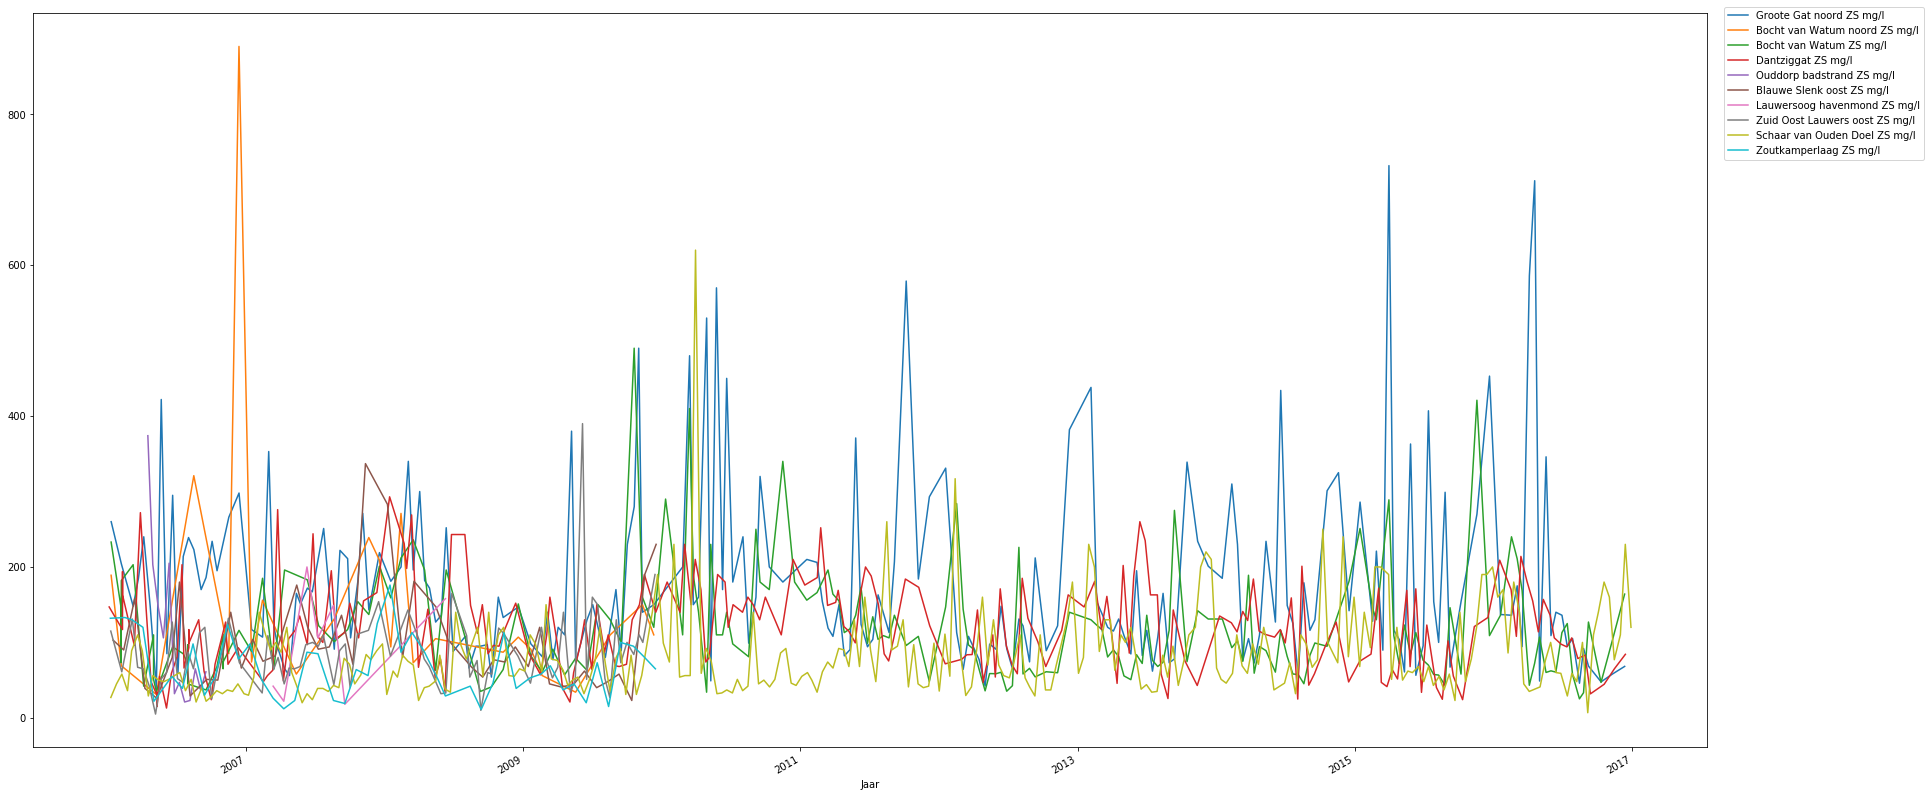

In [12]:
plot_locatie_stof(['Groote Gat noord', 'Bocht van Watum noord', 'Bocht van Watum', 'Dantziggat', 'Ouddorp badstrand', 'Blauwe Slenk oost', 
                   'Lauwersoog havenmond', 'Zuid Oost Lauwers oost', 'Schaar van Ouden Doel', 'Zoutkamperlaag'], ['ZS'], df)

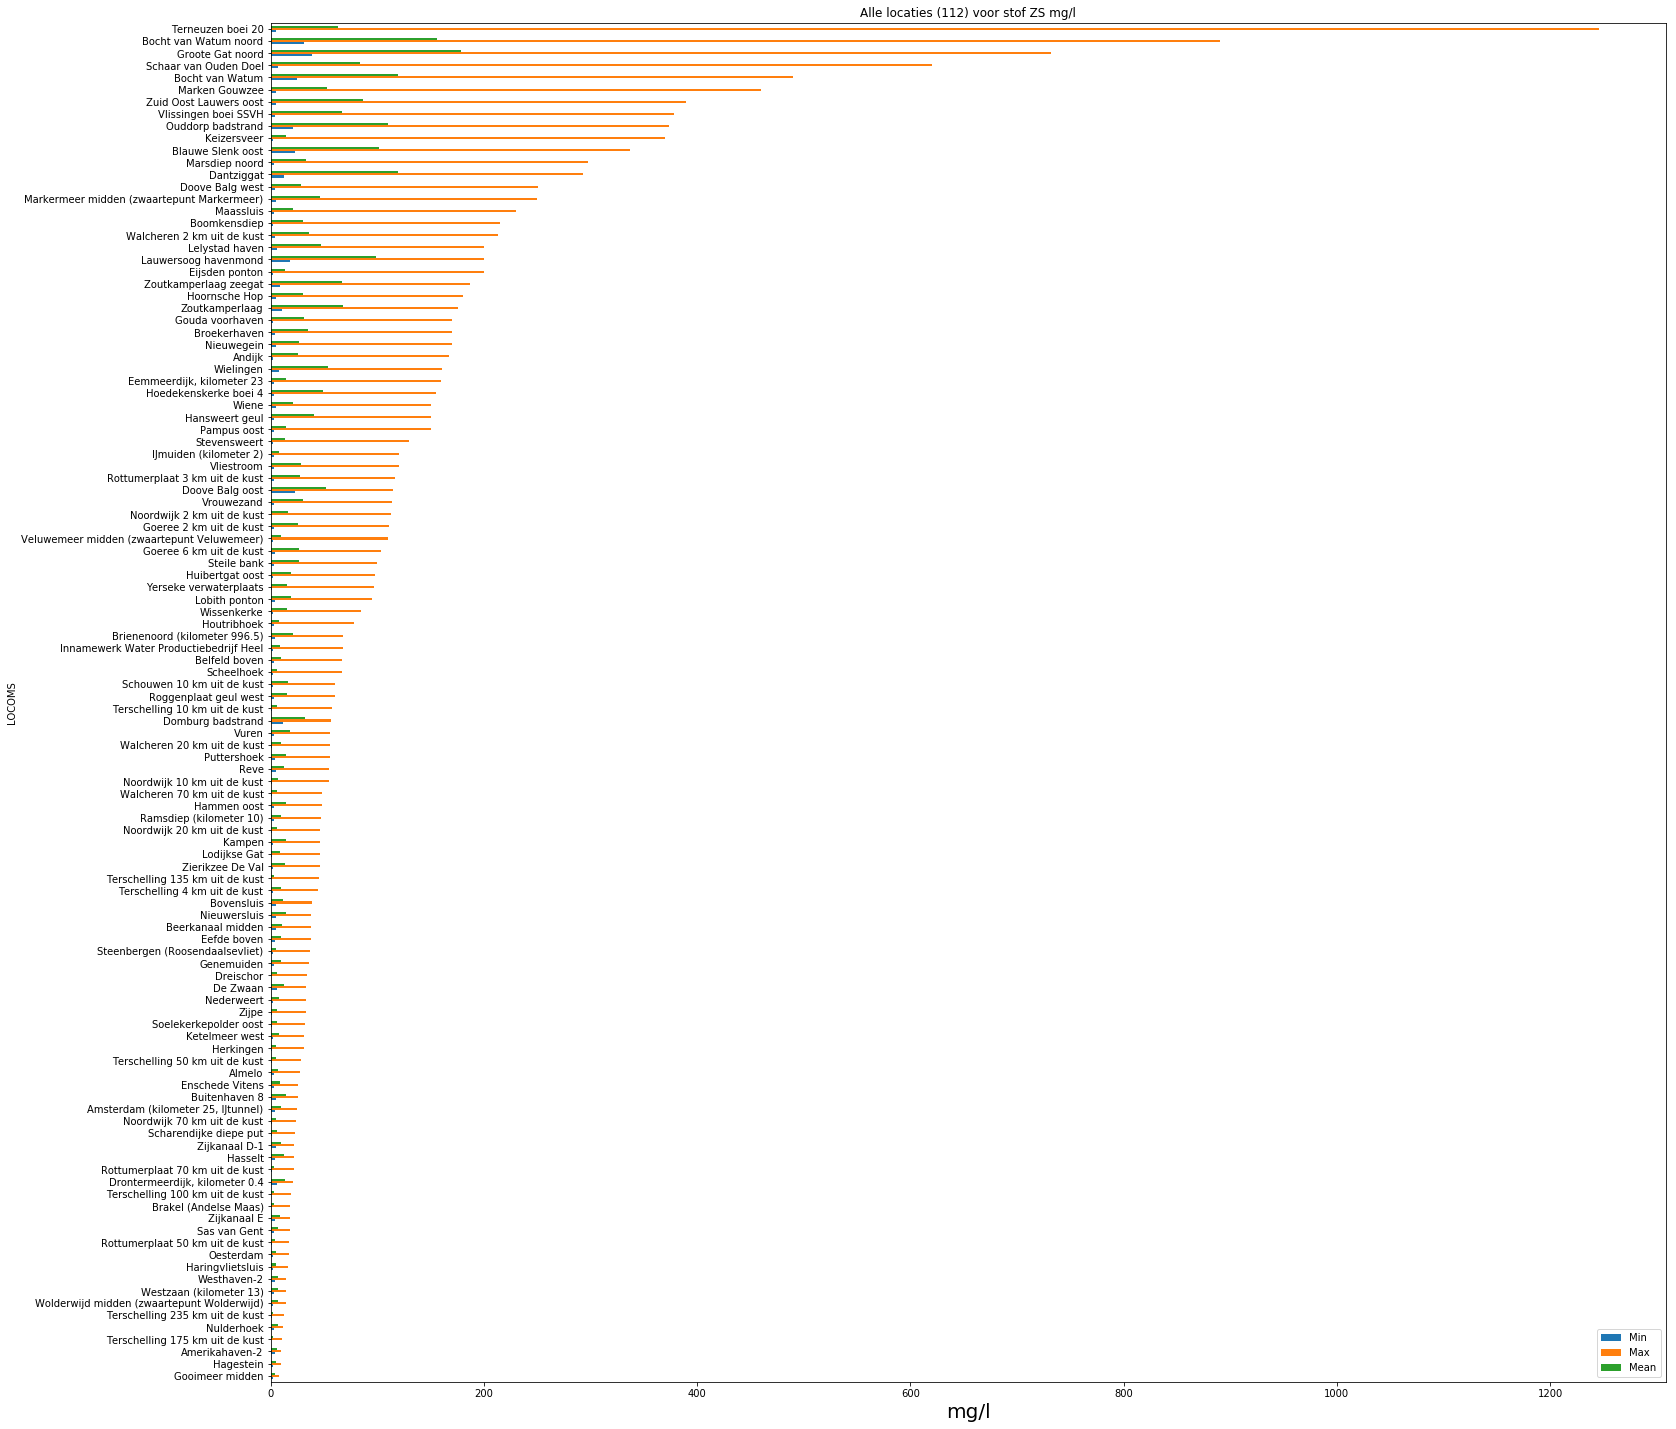

In [13]:
plot_mean_hilo(df, 'ZS', 'Max')

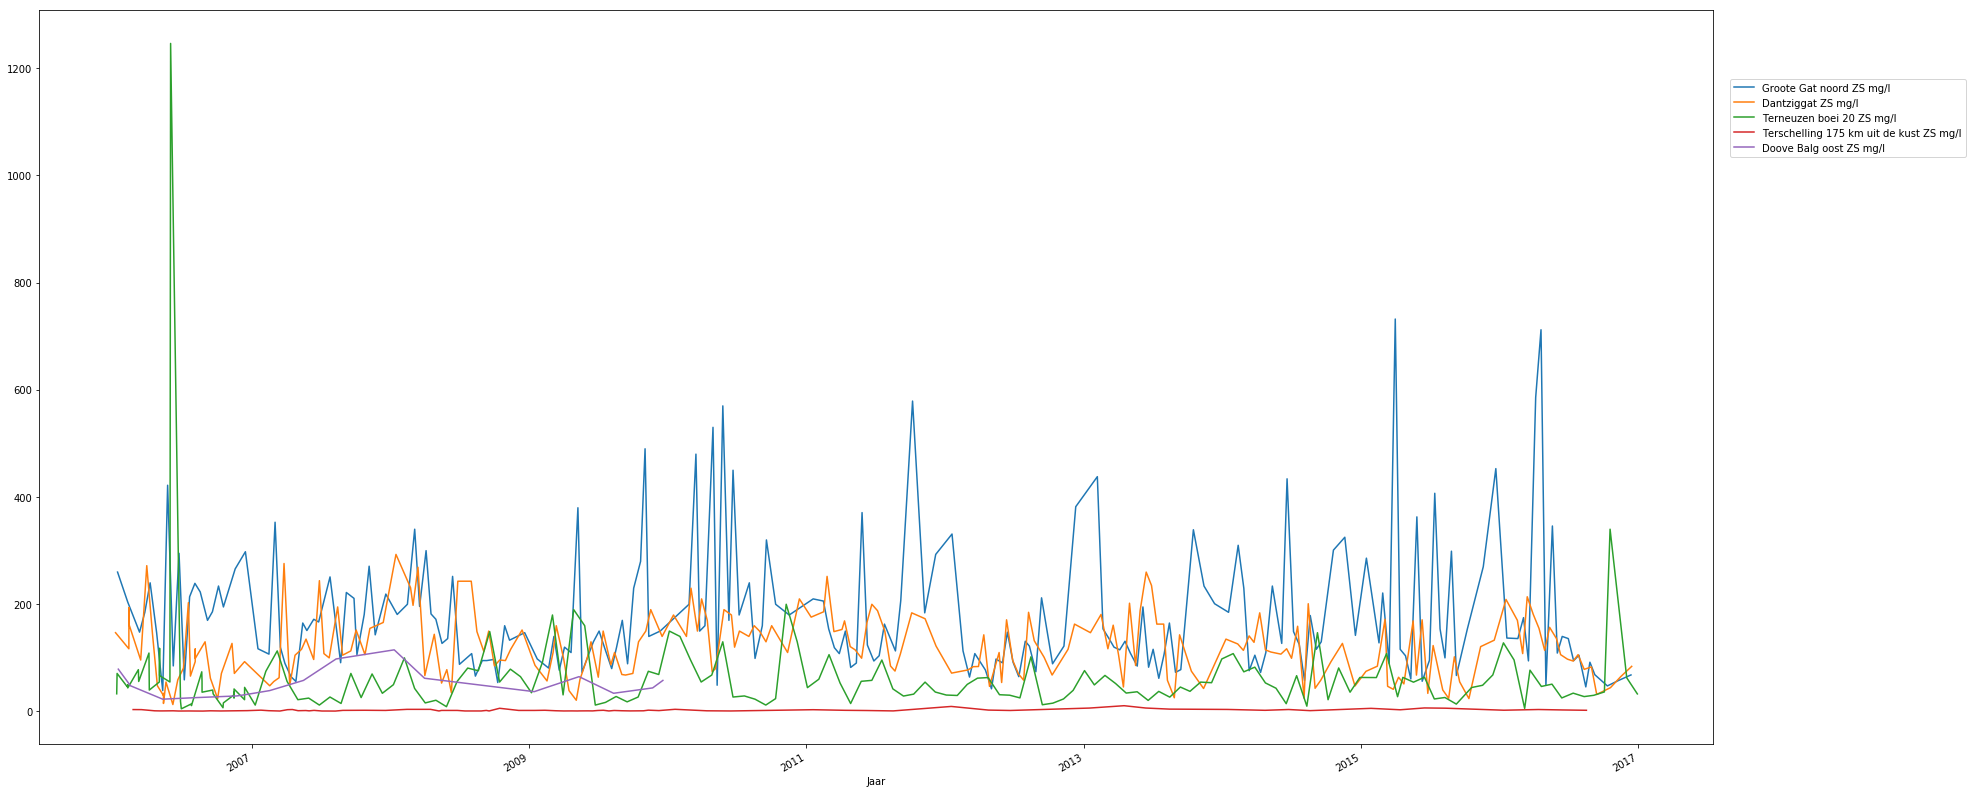

In [14]:
plot_locatie_stof(['Groote Gat noord', 'Dantziggat', 'Terneuzen boei 20', 'Terschelling 175 km uit de kust', 'Doove Balg oost'], ['ZS'] , df)

In [15]:
adam = df[df.LOCOMS ==  'Amsterdam (kilometer 25, IJtunnel)']
adam_gb = adam[['LOCOMS', 'DATUM:TIJD', 'CPM', 'WAARDE', 'PAR']].groupby(['LOCOMS', 'DATUM:TIJD', 'CPM'])['WAARDE'].count()
adam_gb

LOCOMS                              DATUM:TIJD           CPM
Amsterdam (kilometer 25, IJtunnel)  2006-01-24 10:10:00  50      77
                                    2006-01-26 11:52:00  10      31
                                                         80       4
                                    2006-02-23 11:39:00  10      48
                                                         80       4
                                    2006-03-22 08:55:00  50      77
                                    2006-03-23 11:09:00  10     104
                                                         80       4
                                    2006-04-20 10:35:00  10      27
                                                         80       4
                                    2006-05-18 10:35:00  10     102
                                                         80       4
                                    2006-05-19 08:27:00  50      82
                                    2006-06-15 10:51:00

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2345295 entries, 4994 to 1996903
Data columns (total 26 columns):
DATUM:TIJD       datetime64[ns]
PAR              object
BGC              object
WAARDE           float64
KWC              int64
EHD              object
HDH              object
ANA              object
CPM              int64
BEM              object
BTN              object
GBD              object
LOC:COORDSRT     object
LOC:X            int64
LOC:Y            int64
OGI              object
ANI              object
BHI              object
BMI              object
VAT              object
STA:RKSSTATUS    object
LOCOMS           object
X_RD             float64
Y_RD             float64
X_WGS            float64
Y_WGS            float64
dtypes: datetime64[ns](1), float64(5), int64(4), object(16)
memory usage: 483.1+ MB


In [17]:
locoms = df[['LOCOMS', 'X_RD', 'Y_RD', 'LOC:X', 'LOC:Y']].groupby('LOCOMS').max()
no_rd = locoms.loc[locoms.X_RD.isna()]
no_rd

X_RD  Y_RD     LOC:X     LOC:Y
LOCOMS                                                                   
Drontermeerdijk, kilometer 0.4              NaN   NaN  18681400  50605200
Heusden Bernse Veer                         NaN   NaN  13952900  41726300
Hollandsch Diep (mond Dordtsche Kil west)   NaN   NaN  10102500  41395300
Ouddorp badstrand                           NaN   NaN   5430000  42785000
Terschelling 4 km uit de kust               NaN   NaN   5090200  53245500

In [18]:
df.loc[1090,'X_RD']
#= np.where(df[100, 'X_RD'] == np.nan, df[100, 'LOC:X']/100, df[100, 'X_RD'])
#df[['LOCOMS', 'X_RD', 'Y_RD', 'LOC:X', 'LOC:Y']].loc[df.LOCOMS == 'Domburg badstrand']

272952.0

In [19]:
np.where(df['X_RD'].isna(), df['LOC:X']/100, df['X_RD'])

array([-31122., -31122., -31122., ..., 205620., 205620., 205620.])

In [20]:
help(np.is)

SyntaxError: invalid syntax (<ipython-input-20-e683fc12b349>, line 1)

In [ ]:
df.X_RD = [... if np.isna() for x in df['LOC:X']]

In [ ]:
%matplotlib inline

In [ ]:
geometry = [Point(xy) for xy in zip(no_rd['LOC:X']/100, no_rd['LOC:Y']/100)]
geo_df = gpd.GeoDataFrame(geometry = geometry, index=no_rd.index, crs = rd_crs).to_crs(epsg = '4326').reset_index()
map_nl = folium.Map([52.11, 5.39], zoom_start=8, tiles = 'Stamen Toner')
for p in geo_df.itertuples():
    print(p[2].y)
    folium.Marker(
        [p[2].y, p[2].x], 
        popup = p[1]
    ).add_to(map_nl)
map_nl


In [ ]:
par_values = df.PAR.value_counts()
par_values.loc[par_values > 11000]

In [ ]:
df_s = df.loc[df.LOCOMS == 'Almelo']
df_s.reset_index(inplace = True)
df_s_pivot = df_s.pivot_table(index = ['ID'], columns='PAR', values = 'WAARDE')
df_s_pivot.corr().ZS

In [ ]:
df_s = df.loc[df.LOCOMS == 'Almelo']
df_s.reset_index(inplace = True)
df_s_pivot = df_s.pivot_table(index = ['DATUM:TIJD','ID'], columns='PAR', values = 'WAARDE')
df_s_pivot.iloc[1:10,:]

In [ ]:
map_mean_stof('GR', df, 0.6)